# Using `kickscore` to visualize the history of the NBA

This notebook provides an example of `kickscore` applied to a real-dataset.
More specifically, we will look at a dataset containing the [entire history of the NBA](https://github.com/fivethirtyeight/data/tree/master/nba-elo), courtesy of FiveThirtyEight.

If you are not doing so already, you can [launch an interactive notebook on Google Colaboratory](https://colab.research.google.com/github/lucasmaystre/kickscore/blob/master/examples/nba-history.ipynb)

In [ ]:
# This is only needed for when running the notebook on Google Colaboratory.
!pip install kickscore

In [1]:
import csv
import kickscore as ks

from datetime import datetime

%matplotlib inline

## Getting the data

We start by downloading the data locally & parsing it.

In [2]:
!curl https://projects.fivethirtyeight.com/nba-model/nba_elo.csv -o nba_elo.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 8903k  100 8903k    0     0  6545k      0  0:00:01  0:00:01 --:--:-- 6546k


In [3]:
teams = set()
observations = list()

cutoff = datetime(2019, 6, 1).timestamp()

with open("nba_elo.csv") as f:
    for row in csv.DictReader(f):
        t = datetime.strptime(row["date"], "%Y-%m-%d").timestamp()
        if t > cutoff:
            break
        teams.add(row["team1"])
        teams.add(row["team2"])
        if int(row["score1"]) > int(row["score2"]):
            observations.append({
                "winners": [row["team1"]],
                "losers": [row["team2"]],
                "t": t,
            })
        else:
            observations.append({
                "winners": [row["team2"]],
                "losers": [row["team1"]],
                "t": t,
            })

## Fitting a `kickscore` model

We use a single kernel for all teams.
The kernel hyperparameters were found using a grid search, c.f. [the kickscore paper](https://arxiv.org/abs/1903.07746).

In [4]:
# It is a bit more convenient to specify lengthscales in yearly units.
seconds_in_year = 365.25 * 24 * 60 * 60

model = ks.BinaryModel()
kernel = (ks.kernel.Constant(var=0.03)
        + ks.kernel.Matern32(var=0.138, lscale=1.753*seconds_in_year))

In [5]:
for team in teams:
    model.add_item(team, kernel=kernel)

for obs in observations:
    model.observe(**obs)

In [6]:
%%time
converged = model.fit()
if converged:
    print("Model has converged.")

Model has converged.
CPU times: user 4min 10s, sys: 57.1 s, total: 5min 7s
Wall time: 2min 35s


## Analyzing the results

We can now plot the evolution of the teams' skill over time.

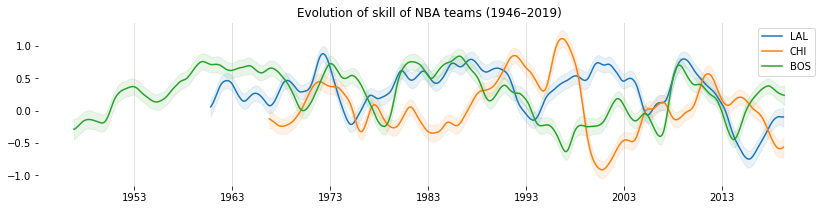

In [7]:
fig, ax = model.plot_scores(
        items=["LAL", "CHI", "BOS"],
        resolution=10/seconds_in_year,
        figsize=(14.0, 3.0),
        timestamps=True)
ax.set_title("Evolution of skill of NBA teams (1946–2019)");

If you know a little bit about NBA history, you can easily spot:

- The domination of Boston Celtics (BOS) in the 60s
- The fantastic 95-96 season of the Chicago Bulls (CHI), led by Michael Jordan, and the subsequent downfall
- The domination of the Los Angeles Lakers (LAL) in the early 00s.

Compare this plot to [that one, by FiveThirtyEight](https://projects.fivethirtyeight.com/complete-history-of-the-nba/).

We can also use the model to compute outcome probabilities at various points in time:

In [8]:
print("Probability that CHI beats BOS...")

p_win, _ = model.probabilities(["CHI"], ["BOS"], t=datetime(1996, 1, 1).timestamp())
print("  ... in 1996: {:.2f}%".format(100 * p_win))

p_win, _ = model.probabilities(["CHI"], ["BOS"], t=datetime(2001, 1, 1).timestamp())
print("  ... in 2001: {:.2f}%".format(100 * p_win))

p_win, _ = model.probabilities(["CHI"], ["BOS"], t=datetime(2020, 1, 1).timestamp())
print("  ... in 2020: {:.2f}%".format(100 * p_win))

Probability that CHI beats BOS...
  ... in 1996: 89.88%
  ... in 2001: 22.89%
  ... in 2020: 27.48%
